In [1]:
import os
import numpy as np
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
from torch.utils.data import Dataset
import cv2
from torch.utils import data
import matplotlib.pyplot as plt
import segmentation_models_pytorch

In [2]:
# Create custom dataset class
class SegNetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(os.path.join(root_dir, 'color-input'))
        self.depths = os.listdir(os.path.join(root_dir, 'depth-input'))
        self.masks  = os.listdir(os.path.join(root_dir, 'label'))


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path    = os.path.join(self.root_dir, 'color-input', self.images[idx])
        depth_path  = os.path.join(self.root_dir, 'depth-input', self.depths[idx])
        mask_path   = os.path.join(self.root_dir, 'label', self.masks[idx])
        image = cv2.imread(img_path)
        depth = cv2.imread(mask_path)
        mask  = cv2.imread(mask_path)
        mask_g  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        gt_mask = self.convert_gray_to_rgb(mask)
        # gt_mask = cv2.cvtColor(gt_mask, cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        def correct_gray(image):
          img_g = np.zeros((image.shape[0], image.shape[1])).astype(np.float32)

          img_g[np.where((image == [0]))] = [0] #unpickable
          img_g[np.where((image == [128]))] = [1.0] #pickable
          img_g[np.where((image == [255]))] = [0] #invalid

          return img_g
        mask_g = correct_gray(mask_g) # correcting grayscale so white is suckable and black is not
        mask_g = np.expand_dims(mask_g, axis=2)

        if self.transform:
            depth = self.transform(depth)
            image = self.transform(image)
            mask_g = self.transform(mask_g)
            gt_mask = self.transform(gt_mask)
        
        return image, mask_g, depth, gt_mask
        
    def convert_gray_to_rgb(self, image):
        # Convert 255 to mask
        rgb_image = np.zeros((image.shape[0], image.shape[1], 3))

        rgb_image[np.where((image == [0, 0, 0]).all(axis = 2))] = [0,0,255]
        rgb_image[np.where((image == [128, 128, 128]).all(axis = 2))] = [0,255,0]
        rgb_image[np.where((image == [255, 255, 255]).all(axis = 2))] = [255,0,0]

        return rgb_image

        
transforms = tf.Compose([
    tf.ToTensor(),
    # tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])    
    ])

dataset = SegNetDataset(root_dir='_data', transform=transforms)

# Split dataset into train and test
train_data, test_data = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True,  num_workers=4)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=4, shuffle=False, num_workers=4)

In [3]:
# Define function to calculate accuracy
def accuracy(outputs, targets):
    # Permute to (B, H, W, C)
    outputs = outputs.permute(0, 2, 3, 1)
    targets = targets.permute(0, 2, 3, 1)

    # Find max value and index of max value
    max_values, _ = torch.max(outputs, dim=3) # Here dim=3 because we want to find max value for class
    outputs_targets = (outputs == max_values.unsqueeze(3)).float().round()

    # Find true positives, false positives, false negatives
    true_positives  = torch.where((outputs_targets > 0.5) & (targets == 1), 1, 0).sum(dim=(0, 1, 2))
    false_positives = torch.where((outputs_targets > 0.5) & (targets == 0), 1, 0).sum(dim=(0, 1, 2))
    false_negatives = torch.where((outputs_targets <= 0.5) & (targets == 1), 1, 0).sum(dim=(0, 1, 2))

    # How to deal with 0 values
    true_positives  = torch.where(true_positives  == 0, 1, true_positives)

    # Calculate recall and precision
    recall = true_positives / (true_positives + false_negatives)
    precision = true_positives / (true_positives + false_positives)

    return recall.item(), precision.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


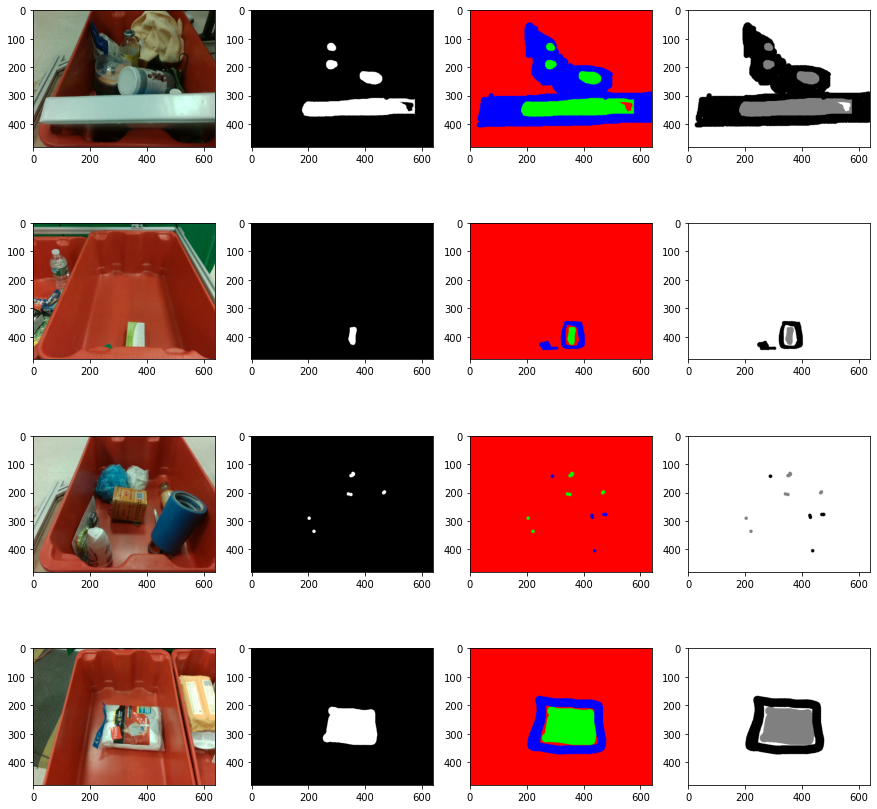

In [4]:
# Load a test batch
images, masks, depths, gt_mask = next(iter(test_loader))
selected_image = 3
# Plot a test batch
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
for i in range(4):
    ax[i, 0].imshow(images[i].permute(1, 2, 0))
    ax[i, 1].imshow(masks[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(gt_mask[i].permute(1, 2, 0))
    ax[i, 3].imshow(depths[i].permute(1, 2, 0))
    if selected_image == i:
        cv2.imwrite('_images/image.png', cv2.cvtColor(images[i].permute(1, 2, 0).numpy()*255, cv2.COLOR_BGR2RGB))
        cv2.imwrite('_images/gt_binarry.png', masks[i].squeeze().numpy()*255)
        cv2.imwrite('_images/gt_multiclass.png', gt_mask[i].permute(1, 2, 0).numpy())
        cv2.imwrite('_images/gt_zeng.png', depths[i].permute(1, 2, 0).numpy()*255)


plt.show()

In [5]:
# Find GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Get ReResNet101 pretrained model to use as encoder
model = segmentation_models_pytorch.Unet(encoder_name='resnet101', 
                                         encoder_weights='imagenet', 
                                         classes=1, 
                                         activation="sigmoid", 
                                         encoder_depth=2, 
                                         decoder_channels = ( 32, 16))

# print(model)
model.encoder.train = False
model.decoder.train = True
model.segmentation_head.train = True

# Print model children
# for name, child in model.named_children():
#     print(name)

# Move model to GPU
model.to(device) #1GB GPU

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [6]:
criterion = torch.nn.BCELoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

In [34]:
# # Clear GPU cache
# torch.cuda.empty_cache()
# try: 
#     del  images, masks, depths, gt_mask, outputs
# except:
#     pass

In [28]:
# # test code for output
# images, masks, depths, gt_mask = next(iter(test_loader))
# images = images.to(device)
# masks = masks.to(device)
# outputs = model(images) # 3GB GPU

# # calculate recall and precision
# recall, precision = accuracy(outputs, masks)

# del  images, masks, depths, gt_mask, outputs

true positive: 23641
false positive: 166401
false negative: 1


In [7]:
# Train model
from matplotlib import pyplot as plt
from IPython.display import clear_output
import csv

plot = True

plt.ion()
# fig, ax = plt.subplots(1, 2, figsize=(15, 15))
plt.figure()
epochs = 10
losses_test, losses_train = [], []
recall_train, precision_train = [], []
recall_test, precision_test = [], []

# Train model
with open('single_class_rgb.csv','w', newline='') as datafile:
    writer = csv.writer(datafile)
    writer.writerow(['epoch', 'loss_train', 'loss_test', 'recall_train', 'precision_train', 'recall_test', 'precision_test'])
    for epoch in range(epochs):
        loss_test_sum = loss_train_sum = 0
        epoch_recall_train = epoch_precision_train = 0

        for i, (images, masks, depths, gt_mask) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)
            depths = depths.to(device)
            optimizer.zero_grad()
            outputs = model(images) # 3GB GPU

            # calculate recall and precision
            recall, precision = accuracy(outputs, masks)
            epoch_recall_train += recall
            epoch_precision_train += precision
            
            # calculate loss and backpropagate
            loss = criterion(outputs, masks)
            loss_train_sum += loss.item() 
            loss.backward()
            optimizer.step()

            del images, gt_mask, depths, outputs, loss, masks
        
        # calculate and save data
        epoch_recall_train /= len(train_loader)
        epoch_precision_train /= len(train_loader)
        recall_train.append(epoch_recall_train)
        precision_train.append(epoch_precision_train)
        
        with torch.no_grad():
            epoch_recall_test = epoch_precision_test = 0
            for i, (images, masks, depth, gt_mask) in enumerate(test_loader):
                images = images.to(device)
                masks = masks.to(device)
                depth = depth.to(device)
                outputs = model(images)
                # calculate recall and precision
                recall, precision = accuracy(outputs, masks)
                epoch_recall_test += recall
                epoch_precision_test += precision

                #calculate loss
                loss = criterion(outputs, masks)
                loss_test_sum += loss.item()
                del images, gt_mask, depth, loss
            
            # calculate and save data
            epoch_recall_test /= len(test_loader)
            epoch_precision_test /= len(test_loader)
            recall_test.append(epoch_recall_test)
            precision_test.append(epoch_precision_test)
        
        # write data to csv file
        writer.writerow([epoch, losses_train[-1], losses_test[-1], recall_train[-1], precision_train[-1], recall_test[-1], precision_test[-1]])
        losses_train.append(loss_train_sum/len(train_loader))
        losses_test.append(loss_test_sum/len(test_loader))  

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {losses_train[-1]}, Validation Loss: {losses_test[-1]}')
        print(f'Epoch [{epoch+1}/{epochs}], Train Recall: {recall_train[-1]}, Train Precision: {precision_train[-1]}')
        if plot:
            plt.imshow(outputs[0].squeeze().cpu().detach().numpy().astype('float32'), cmap='gray')
            plt.show()
            plt.imshow(masks[0].squeeze().cpu(), cmap='gray')
            plt.show()
            # plt.pause(0.005)
            clear_output(wait=True)
        del outputs, masks


IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

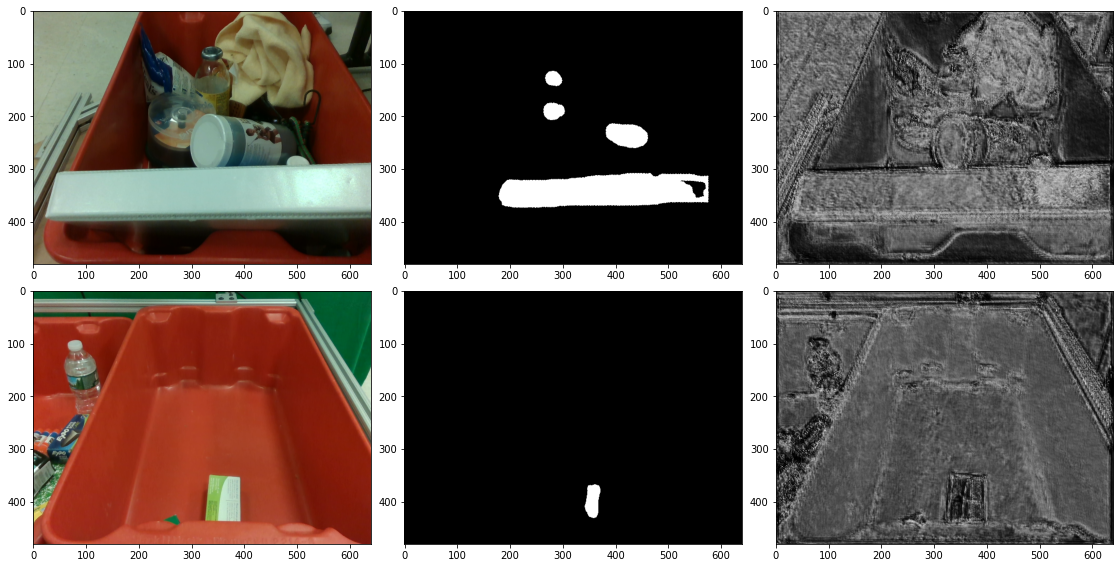

In [19]:
images, masks, depths, gt_mask = next(iter(test_loader))
# Plot a test batch
fig, ax = plt.subplots(2, 3, figsize=(15, 15))
affordance_map = 0
for i in range(2):
    output = model(images[i].unsqueeze(0).to(device)).squeeze().cpu().detach().numpy().astype('float32')
    ax[i, 0].imshow(images[i].permute(1, 2, 0))
    ax[i, 1].imshow(masks[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(output, cmap='gray')
    if i == 0:
        # affordance_map = masks[i].squeeze().cpu().detach().numpy().astype('float32')
        affordance_map = output

plt.subplots_adjust(left=0.0,
                    bottom=0.0,
                    right=1,
                    top=1,
                    wspace=0.1,
                    hspace=-0.65)
plt.show()

1


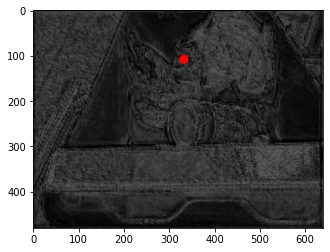

In [23]:
def find_max_position(arr: np.ndarray):
    max_val = np.max(arr)
    max_pos = np.where(arr == max_val)
    n_pos = len(max_pos[0])
    return max_pos, n_pos
pos, n_pos = find_max_position(affordance_map)
print(n_pos)
# make pick_map 3D array
pick_map = np.zeros((affordance_map.shape[0], affordance_map.shape[1], 3))
# coppy affordance map to pick map
pick_map[:, :, 0] = affordance_map/2
pick_map[:, :, 1] = affordance_map/2
pick_map[:, :, 2] = affordance_map/2
# make pick position red
# pick_map[pos[0], pos[1], 0] = 1
# make circle at all pick positions
for i in range(len(pos[0])):
    cv2.circle(pick_map, (pos[1][i], pos[0][i]), 10, (1, 0, 0), -1)

plt.imshow(pick_map)

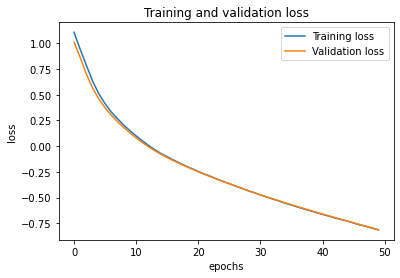

<Figure size 432x288 with 0 Axes>

In [9]:
# Plot losses
plt.plot(losses_train, label='Training loss')
plt.plot(losses_test, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.savefig("loss.png")

In [11]:
# save model as onnx
images, masks, depths, gt_mask = next(iter(test_loader))
torch.onnx.export(model, images[0].unsqueeze(0).to(device), "model.onnx", verbose=True)

TypeError: 'bool' object is not callable